# Self Supervised Learning - learn rotation of images

### References:
* https://d4nst.github.io/2017/01/12/image-orientation/
* https://towardsdatascience.com/a-different-kind-of-deep-learning-part-1-90fe6c52f1ab
* https://openreview.net/forum?id=S1v4N2l0-

In [256]:
from keras.datasets import mnist
from keras.layers.core import Activation
from keras.layers import Conv2D, Dense, Flatten, BatchNormalization, MaxPooling2D, Dropout
from keras.models import Sequential, Model, Input, model_from_json
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, ReduceLROnPlateau
from keras.preprocessing.image import Iterator
from keras.utils.np_utils import to_categorical
import keras.backend as K
import tensorflow as tf

from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.io import imread
import cv2
import os

In [257]:
# Load data set and split to train, val, test
(X_train_origin, Y_train_origin), (X_test, Y_test)  = mnist.load_data()
X_train, X_val, Y_train, Y_val = train_test_split(X_train_origin, Y_train_origin, test_size=0.2, random_state=42)
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

n_train_samples, img_rows, img_cols, img_channels = X_train.shape
input_shape = (img_rows, img_cols, img_channels)
n_test_samples = X_test.shape[0]
n_val_samples = X_val.shape[0]
n_logits = 4
X_train = X_train.astype('float') / 255
X_val = X_val.astype('float') / 255
X_test = X_test.astype('float') / 255

# Step 1: MNIST dataset, try to predict only between 0,90,180,270

## Create costum generator that rotate images and create labels on the fly

In [258]:
count = 0
rot_dict = {0:0, 1: 90, 2: 180, 3: 270}
def generator(imgs, batch_size, plot_debug=False):
    # Create empty arrays to contain batch of features and labels
    global count
    origin_imgs = np.zeros((batch_size, 28, 28, 1), dtype='float32')
    batch_imgs = np.zeros((batch_size, 28, 28, 1), dtype='float32')
    batch_labels = np.zeros((batch_size, n_logits))
    while True:
        for i in range(batch_size):
            # choose random index in features
            index = np.random.choice(imgs.shape[0], 1)
            rotation_angle_ind = np.random.choice(np.arange(n_logits))
            im = imgs[index][0]
            origin_imgs[i] = im
            batch_imgs[i] = np.rot90(im, axes=(1, 0), k=rotation_angle_ind)
            batch_labels[i] = to_categorical(rotation_angle_ind, n_logits)
            
            if count % 1000 == 0 and plot_debug == True:
                fig, ax = plt.subplots(1, 2)
                lbl = batch_labels[count % batch_size]
                ax[0].imshow(origin_imgs[count % batch_size,:,:,0], cmap='gray')
                ax[0].axis('off')                
                ax[0].set_title('original')
                ax[1].imshow(batch_imgs[count % batch_size,:,:,0], cmap='gray')
                ax[1].axis('off')
                ax[1].set_title('rotated')
                plt.suptitle('label: {}\n {}'.format(lbl, rot_dict[np.argmax(lbl)]))
                plt.savefig('/Users/nimrodshabtay/rotation_output/figure_mnist_{}.png'.format(count))
                plt.close()
                
            count += 1
            
        yield batch_imgs, batch_labels

## Model definition

In [259]:
# Parameters
n_filters = 64
kernel_size = (3, 3)
n_classes = 4
model_name = 'rot_mnist_0_all_data'

model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', input_shape=X_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same'))
model.add(Activation('elu'))
model.add(BatchNormalization())
 
model.add(Conv2D(64, (3,3), padding='same'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
 
model.add(Conv2D(128, (3,3), padding='same'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
 
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))
 
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

callbacks_list = [
    ModelCheckpoint(filepath=os.path.join('/Users/nimrodshabtay/rotation_output/',model_name + '.hdf5'), 
                    save_best_only=True),
    EarlyStopping(patience=8)            
]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
activation_7 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 28, 28, 64)        18496     
__________

In [260]:
# training parameters:
batch_size = 32
n_epochs = 50

Epoch 1/50
1500/1500 [==============================] - 573s 382ms/step - loss: 0.9926 - acc: 0.7655 - val_loss: 0.6736 - val_acc: 0.7373
Epoch 2/50
1500/1500 [==============================] - 562s 374ms/step - loss: 0.7608 - acc: 0.8005 - val_loss: 1.1057 - val_acc: 0.3496
Epoch 3/50
1500/1500 [==============================] - 564s 376ms/step - loss: 0.6581 - acc: 0.8309 - val_loss: 0.3331 - val_acc: 0.9442
Epoch 4/50
1500/1500 [==============================] - 585s 390ms/step - loss: 0.6128 - acc: 0.8464 - val_loss: 1.2394 - val_acc: 0.4013
Epoch 5/50
1500/1500 [==============================] - 576s 384ms/step - loss: 0.5785 - acc: 0.8611 - val_loss: 0.5381 - val_acc: 0.8530
Epoch 6/50
1500/1500 [==============================] - 578s 385ms/step - loss: 0.5823 - acc: 0.8616 - val_loss: 1.3799 - val_acc: 0.2958
Epoch 7/50
1500/1500 [==============================] - 591s 394ms/step - loss: 0.5614 - acc: 0.8681 - val_loss: 0.7190 - val_acc: 0.8135
Epoch 8/50
1500/1500 [============

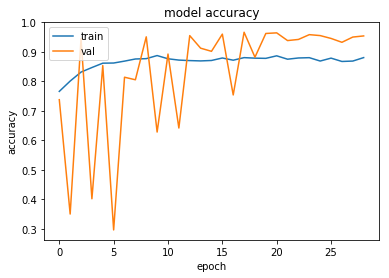

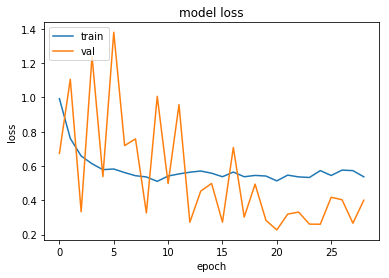

In [261]:
history = model.fit_generator(generator(
        imgs=X_train,
        batch_size=batch_size,
    ),
    steps_per_epoch=n_train_samples / batch_size,
    epochs=n_epochs,
    validation_data=generator(
        X_val,
        batch_size=batch_size,
    ),
    validation_steps=n_val_samples / batch_size,
    verbose=1,
    callbacks=callbacks_list)

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')


In [264]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

# load json and create model
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model`
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")

Saved model to disk


## Visualize the prediction over unseen dataset

Accuracy: 0.978


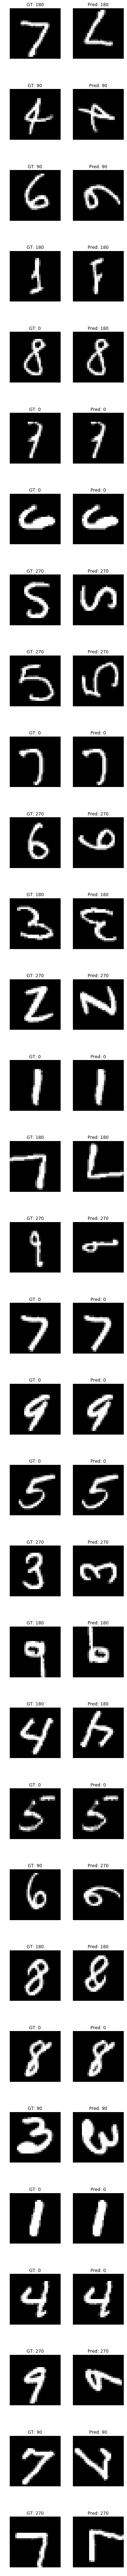

In [262]:
X_test_rot = np.zeros_like(X_test)
fig, ax = plt.subplots(32, 2, figsize=(5,100))
k=0
tp = 0
for i in range(X_test.shape[0]):
    cur_img = X_test[i]
    random_rot_ind = np.random.randint(0,4)
    img_test_rot = np.rot90(cur_img, axes=(1,0), k=random_rot_ind)
    X_test_rot[i] = img_test_rot
    pred = model.predict_classes(x=np.expand_dims(np.expand_dims(X_test_rot[i], -1), axis=0))[0]
    if pred == random_rot_ind: tp+=1
        
    if i % 300 == 0 and k < 32:
        ax[k][1].imshow(img_test_rot, cmap='gray')
        ax[k][0].imshow(cur_img, cmap='gray')
        ax[k][1].axis('off')
        ax[k][0].axis('off')
        ax[k][1].set_title('Pred: {}'.format(rot_dict[pred]))
        ax[k][0].set_title('GT: {}'.format(rot_dict[random_rot_ind]))
        k+=1
plt.tight_layout()
print("Accuracy: {}".format(tp / X_test.shape[0]))

In [263]:
loss, acc_score = model.evaluate_generator(generator(
        imgs=np.expand_dims(X_test, axis=-1),
        batch_size=batch_size,
    ),
    steps=n_test_samples / batch_size)

print (loss, acc_score)

0.3671087030880748 0.9649560702875399


# Step 2: MNIST dataset, Try to predict 360 degrees
### First let's understand what is the maximum bounding box that needed to not crop the image
<img src='boundingbox.jpg'>

Bounding box is set to: 40


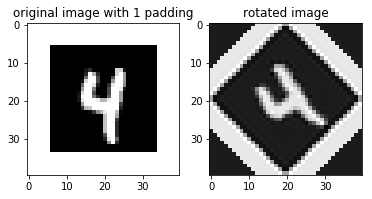

In [179]:
from scipy.ndimage import rotate
from math import sin, cos, pi
# How to calculate the needed bounding box of a rotated image
ang = pi / 4 # 45 dsegress in radians
den = cos(ang) + sin(ang)
s_ = 28
s_tag = (np.round(s_ * den)).astype(np.int32)
print('Bounding box is set to: {}'.format(s_tag))
fig, ax = plt.subplots(1,2)
padded_img = np.ones((s_tag,s_tag,1), dtype=np.float32)
padded_img[(s_tag-28)//2:28+(s_tag-28)//2, (s_tag-28)//2:28+(s_tag-28)//2,:] = X_train[10]
ax[0].set_title('original image with 1 padding')
ax[1].set_title('rotated image')
ax[0].imshow(padded_img[:,:,0], cmap='gray')
rot_pad_img = rotate(padded_img, 45, reshape=False)
ax[1].imshow(rot_pad_img[:,:,0], cmap='gray')

In [195]:
count_360 = 0
n_logits_360 = 360

def angle_difference(x, y):
    """
    Calculate minimum difference between two angles.
    """
    return 180 - abs(abs(x - y) - 180)

def angle_error(y_true, y_pred):
    """
    Calculate the mean diference between the true angles
    and the predicted angles. Each angle is represented
    as a binary vector.
    """
    diff = angle_difference(K.argmax(y_true), K.argmax(y_pred))
#     diff = K.print_tensor(diff, message='difference: ')
    return K.mean(K.cast(K.abs(diff), K.floatx()))

def generator_360(imgs, batch_size, plot_debug=False):
    # Create empty arrays to contain batch of features and labels
    global count_360
    origin_imgs = np.zeros((batch_size, s_, s_, 1), dtype='float32')
    batch_imgs = np.zeros((batch_size, s_, s_, 1), dtype='float32')
    batch_labels = np.zeros((batch_size, n_logits_360))
    while True:
        for i in range(batch_size):
            # choose random index in features
            index = np.random.choice(imgs.shape[0], 1)
            rotation_angle = np.random.choice(np.arange(n_logits_360))
            im = imgs[index][0]
            origin_imgs[i] = im
            batch_imgs[i] = rotate(origin_imgs[i], rotation_angle, reshape=False)
            batch_labels[i] = to_categorical(rotation_angle, n_logits_360)
            
            if count_360 % 1000 == 0 and plot_debug == True:
                fig, ax = plt.subplots(1, 2)
                lbl = batch_labels[count_360 % batch_size]
                ax[0].imshow(origin_imgs[count_360 % batch_size,:,:,0], cmap='gray')
                ax[0].axis('off')                
                ax[0].set_title('original')
                ax[1].imshow(batch_imgs[count_360 % batch_size,:,:,0], cmap='gray')
                ax[1].axis('off')
                ax[1].set_title('rotated')
                plt.suptitle('label: {}'.format(rotation_angle))
                plt.savefig('/Users/nimrodshabtay/rotation_output/figure_mnist_360_val_{}.png'.format(count_360))
                plt.close()
                
            count_360 += 1
            
        yield batch_imgs, batch_labels

In [240]:
model_name = 'rot360_mnist_0_no_resize_all_data'
n_classes_360 = 360
dropout_rate = 0.3
n_fc = 128
n_filters_360 = 64
input_shape_padded = (s_, s_, 1)
model_360 = Sequential()
model_360.add(Conv2D(n_filters_360, kernel_size, activation='relu', padding='same', 
                     input_shape=input_shape_padded))
model_360.add(Conv2D(n_filters_360, kernel_size, activation='relu', padding='same'))
model_360.add(Conv2D(n_filters_360, kernel_size, activation='relu', padding='same'))
model_360.add(MaxPooling2D(pool_size=(2, 2)))
model_360.add(Dropout(dropout_rate))
model_360.add(Flatten())
model_360.add(Dense(n_fc, activation='relu'))
model_360.add(Dropout(dropout_rate))
model_360.add(Dense(n_classes_360, activation='softmax'))

model_360.summary()

model_360.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[angle_error])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               1605760   
__________

Epoch 1/50
1500/1500 [==============================] - 237s 158ms/step - loss: 2.3489 - angle_error: 11.0323 - val_loss: 1.8348 - val_angle_error: 4.0323
Epoch 2/50
1500/1500 [==============================] - 251s 167ms/step - loss: 2.3562 - angle_error: 11.1741 - val_loss: 1.7191 - val_angle_error: 4.3470
Epoch 3/50
1500/1500 [==============================] - 238s 159ms/step - loss: 2.3256 - angle_error: 11.0824 - val_loss: 1.7584 - val_angle_error: 4.3193
Epoch 4/50
1500/1500 [==============================] - 237s 158ms/step - loss: 2.3457 - angle_error: 11.1669 - val_loss: 1.7302 - val_angle_error: 3.8383
Epoch 5/50
1500/1500 [==============================] - 233s 155ms/step - loss: 2.3226 - angle_error: 11.3575 - val_loss: 1.6627 - val_angle_error: 4.6981
Epoch 6/50
1500/1500 [==============================] - 232s 155ms/step - loss: 2.2793 - angle_error: 11.3640 - val_loss: 1.6321 - val_angle_error: 3.4475
Epoch 7/50
1500/1500 [==============================] - 232s 154ms/ste

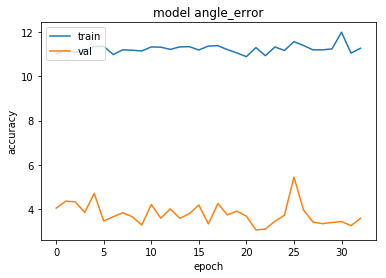

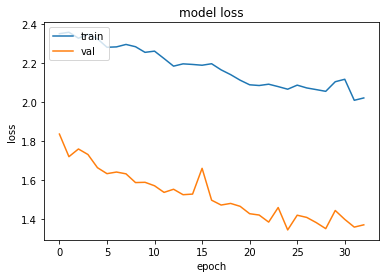

In [217]:
callbacks_list = callbacks_list = [
    ModelCheckpoint(filepath=os.path.join('/Users/nimrodshabtay/rotation_output/',model_name + '.hdf5'), 
                    save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=8),
    ReduceLROnPlateau()
]
history_360 = model_360.fit_generator(generator_360(
        imgs=X_train,
        batch_size=batch_size,
        plot_debug=False
    ),
    steps_per_epoch=n_train_samples / batch_size,
    epochs=n_epochs,
    validation_data=generator_360(
        X_val,
        batch_size=batch_size,
        plot_debug=True
    ),
    validation_steps=n_val_samples / batch_size,
    verbose=1,
    callbacks=callbacks_list)

# summarize history for angle error
plt.plot(history_360.history['angle_error'])
plt.plot(history_360.history['val_angle_error'])
plt.title('model angle_error')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_360.history['loss'])
plt.plot(history_360.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

### first 50 epochs

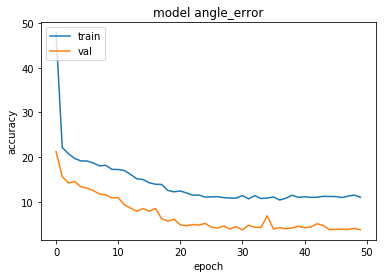

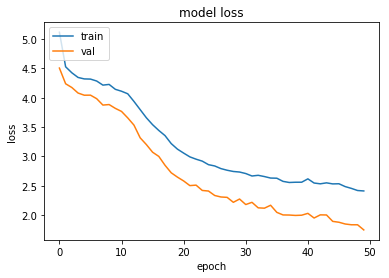

In [216]:
# summarize history for angle error
plt.plot(history_360.history['angle_error'])
plt.plot(history_360.history['val_angle_error'])
plt.title('model angle_error')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_360.history['loss'])
plt.plot(history_360.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [241]:
# model_json_360 = model_360.to_json()
# with open("model_360.json", "w") as json_file:
#     json_file.write(model_json_360)
# model_360.save_weights("model_360.h5")
# print("Saved model_360 to disk")

# json_file = open('model_360.json', 'r')
# loaded_model_json_360 = json_file.read()
# json_file.close()
# loaded_model_360 = model_from_json(loaded_model_json_360)
# loaded_model_360.load_weights("model_360.h5")
# print("Loaded model_360 from disk")

Saved model_360 to disk


### Visualize predictions on validation set

Accuracy: 0.9710833333333333


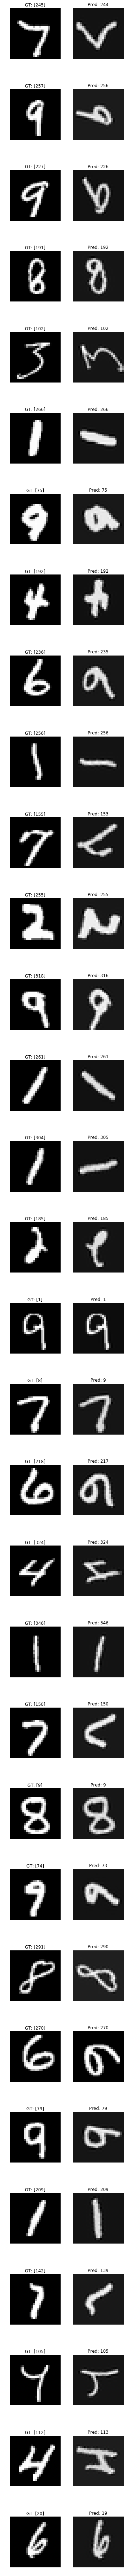

In [230]:
X_val_rot = np.zeros_like(X_val)
fig, ax = plt.subplots(32, 2, figsize=(5,100))
k=0
tp = 0
for i in range(X_val.shape[0]):
    cur_img = X_val[i]
    rotation_angle = np.random.choice(np.arange(n_logits_360))
    img_test_rot = rotate(cur_img, rotation_angle, reshape=False)
    X_val_rot[i] = img_test_rot
    pred = model_360.predict_classes(x=np.expand_dims(X_val_rot[i], axis=0))[0]
    if angle_difference(rotation_angle, pred) < 5: tp+=1
        
    if i % 300 == 0 and k < 32:        
        ax[k][1].imshow(img_test_rot[:, :, 0], cmap='gray')
        ax[k][0].imshow(cur_img[:,:,0], cmap='gray')
        ax[k][1].axis('off')
        ax[k][0].axis('off')
        ax[k][1].set_title('Pred: {}'.format(pred))
        ax[k][0].set_title('GT: {}'.format([rotation_angle]))
        k+=1
plt.tight_layout()
print("Accuracy: {}".format(tp / X_val.shape[0]))

### Visualize predictions on Test set

Accuracy: 0.9725


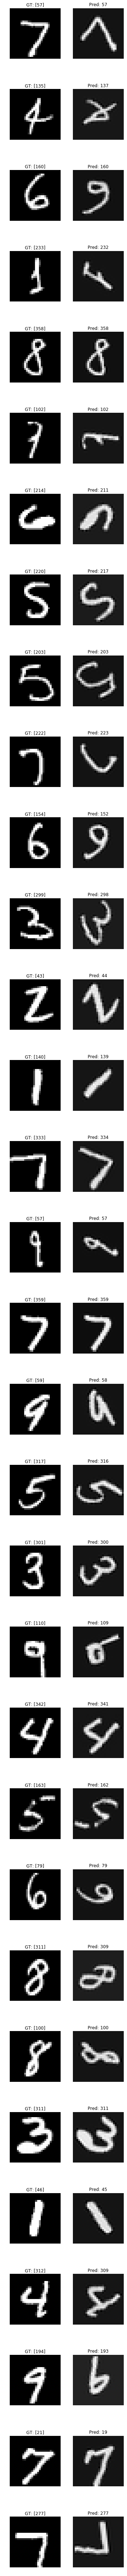

In [236]:
X_test_rot = np.zeros_like(X_test)
fig, ax = plt.subplots(32, 2, figsize=(5,100))
k=0
tp = 0
for i in range(X_test.shape[0]):
    cur_img = X_test[i]
    rotation_angle = np.random.choice(np.arange(n_logits_360))
    img_test_rot = rotate(cur_img, rotation_angle, reshape=False)
    X_test_rot[i] = img_test_rot
    pred = model_360.predict_classes(x=np.expand_dims(np.expand_dims(X_test_rot[i], axis=0), axis=-1))[0]
    if angle_difference(rotation_angle, pred) < 5: tp+=1
        
    if i % 300 == 0 and k < 32:        
        ax[k][1].imshow(img_test_rot, cmap='gray')
        ax[k][0].imshow(cur_img, cmap='gray')
        ax[k][1].axis('off')
        ax[k][0].axis('off')
        ax[k][1].set_title('Pred: {}'.format(pred))
        ax[k][0].set_title('GT: {}'.format([rotation_angle]))
        k+=1
plt.tight_layout()
print("Accuracy: {}".format(tp / X_test.shape[0]))